## Application of BPR on Zazzle Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import itertools
import numpy as np
import pandas as pd
from subprocess import call
from pybpr import *
import scipy.sparse as sp
from functools import reduce
import matplotlib.pyplot as plt
from functools import partial

## Process data from Zazzle

In [3]:
%%time
data_dir = os.path.join(os.path.curdir, 'data', 'NREL')
files = [os.path.join(data_dir,f'Clicks_{str(ix).zfill(4)}_part_00.parquet') for ix in range(80)]
df = pd.concat([pd.read_parquet(ifile) for ifile in files])
cdf = df[df['is_click']].copy() # click data
vdf = df[~df['is_click']].copy() # not click is view data
#df_click = df_click[~df_click['is_click']].copy()

CPU times: user 6.05 s, sys: 2.17 s, total: 8.22 s
Wall time: 42.1 s


In [4]:
%%time
files = [os.path.join(data_dir,f'OrderItems_{str(ix).zfill(4)}_part_00.parquet') for ix in range(80)]
odf = pd.concat([pd.read_parquet(ifile) for ifile in files])

CPU times: user 165 ms, sys: 76.6 ms, total: 241 ms
Wall time: 2.17 s


In [5]:
%%time
files = [os.path.join(data_dir,f'Products_{str(ix).zfill(4)}_part_00.parquet') for ix in range(80)]
pdf = pd.concat([pd.read_parquet(ifile) for ifile in files])

CPU times: user 2.56 s, sys: 959 ms, total: 3.52 s
Wall time: 14.9 s


In [6]:
vdf.drop(columns=['is_click','cleaned_url'], inplace=True, errors='ignore')
cdf.drop(columns=['is_click','cleaned_url'], inplace=True, errors='ignore')
cdf = pd.concat([cdf, odf]) # ensures order data is part of click data
vdf = pd.concat([vdf, cdf]) # ensures click data is part of view data

In [7]:
odf.head()

,user_id,date_created,product_id
0,011fd642-8268-4b30-a9ab-038ffa5a33b6,1675585562,256455388267258097
1,011fd642-8268-4b30-a9ab-038ffa5a33b6,1675585562,228981329284404608
2,011fd642-8268-4b30-a9ab-038ffa5a33b6,1678206962,256009884926995133
3,011fd642-8268-4b30-a9ab-038ffa5a33b6,1678206962,256944911110360906
4,011fd642-8268-4b30-a9ab-038ffa5a33b6,1678206962,256996950913031084


In [8]:
# remove repeated entries
cdf.drop_duplicates(subset=['user_id','product_id'], keep='last', inplace=True)
vdf.drop_duplicates(subset=['user_id','product_id'], keep='last', inplace=True)
odf.drop_duplicates(subset=['user_id','product_id'], keep='last', inplace=True)

In [9]:
print(f'Views:  int={vdf.shape[0]} u={vdf.user_id.nunique()} i={vdf.product_id.nunique()}')
print(f'Clicks: int={cdf.shape[0]} u={cdf.user_id.nunique()} i={cdf.product_id.nunique()}')
print(f'Orders: int={odf.shape[0]} u={odf.user_id.nunique()} i={odf.product_id.nunique()}')

Views:  int=28927112 u=16511 i=779192
Clicks: int=833698 u=16402 i=313452
Orders: int=266638 u=16302 i=139654


In [10]:
# make sure atleast some interaction data for each user/item
idf = vdf.groupby('user_id')['product_id'].count().gt(5)
valid_users = idf[idf].index.to_numpy()
jdf = vdf.groupby('product_id')['user_id'].count().gt(5)
valid_items = jdf[jdf].index.to_numpy()
print(f'Valid Users = {valid_users.shape[0]}')
print(f'Valid Items = {valid_items.shape[0]}')

Valid Users = 16462
Valid Items = 779192


In [11]:
common_users = reduce(np.intersect1d, (vdf.user_id, cdf.user_id, odf.user_id, valid_users))
common_users = valid_users
vdf = vdf[vdf.user_id.isin(common_users)].copy()
cdf = cdf[cdf.user_id.isin(common_users)].copy()
odf = odf[odf.user_id.isin(common_users)].copy()
print(vdf.user_id.nunique(), cdf.user_id.nunique(), odf.user_id.nunique())
common_items = reduce(np.intersect1d, (vdf.product_id, cdf.product_id, odf.product_id, valid_items))
common_items=valid_items
vdf = vdf[vdf.product_id.isin(common_items)].copy()
cdf = cdf[cdf.product_id.isin(common_items)].copy()
odf = odf[odf.product_id.isin(common_items)].copy()
print(vdf.product_id.nunique(), cdf.product_id.nunique(), odf.product_id.nunique())

16462 16375 16278
779192 313420 139623


In [12]:
# %%time
# # get indices for users and products
# for cname in ['user_id','product_id']:
#     vdf[cname] = vdf[cname].astype('category')
#     vdf[f'{cname}x'] = vdf[cname].cat.codes.astype(int)
#     cdf[cname] = pd.Categorical(
#         cdf[cname], 
#         categories=vdf[cname].unique(), 
#         ordered=False
#     )
#     cdf[f'{cname}x'] = cdf[cname].cat.codes.astype(int)
#     odf[cname] = pd.Categorical(
#         odf[cname], 
#         categories=vdf[cname].unique(), 
#         ordered=False
#     )
#     odf[f'{cname}x'] = odf[cname].cat.codes.astype(int)
# cname='product_id'
# pdf[cname] = pd.Categorical(
#     pdf[cname], 
#     categories=vdf[cname].unique(), 
#     ordered=False
# )
# pdf[f'{cname}x'] = pdf[cname].cat.codes.astype(int)
# # odf.groupby('product_id')['user_id'].count().sort_values()

In [13]:
# add index columns
vdf, (cdf, odf, pdf) = generate_user_item_indices(
    parent_df = vdf, 
    children_dfs = [cdf, odf, pdf],
    userid_column = 'user_id',
    itemid_column = 'product_id',
    index_suffix='x'
)

In [14]:
vdf.reset_index(inplace=True, drop=True)
cdf.reset_index(inplace=True, drop=True)
odf.reset_index(inplace=True, drop=True)

In [15]:
vdf.to_parquet(os.path.join(os.path.curdir, 'output', 'zazzle_data', 'view_data.parquet'))
cdf.to_parquet(os.path.join(os.path.curdir, 'output', 'zazzle_data', 'click_data.parquet'))
odf.to_parquet(os.path.join(os.path.curdir, 'output', 'zazzle_data', 'order_data.parquet'))

## Create pos/neg pair datasets

In [16]:
idf = vdf.merge(cdf, on=['user_id','product_id'], how='left', indicator=True)
df_viewed_but_not_clicked = vdf[(idf['_merge']=='left_only').values]

In [17]:
idf = cdf.merge(odf, on=['user_id','product_id'], how='left', indicator=True)
df_clicked_but_not_ordered = cdf[(idf['_merge']=='left_only').values]

In [26]:
# check if compatible
df_viewed_but_not_clicked.shape[0], cdf.shape[0], vdf.shape[0]
df_clicked_but_not_ordered.shape[0], odf.shape[0], cdf.shape[0]

(567047, 266598, 833645)

In [19]:
df_viewed_but_not_clicked.to_parquet(os.path.join(os.path.curdir, 'output', 'zazzle_data', 'viewed_not_clicked_data.parquet'))
df_clicked_but_not_ordered.to_parquet(os.path.join(os.path.curdir, 'output', 'zazzle_data', 'clicked_not_ordered_data.parquet'))

## Plotting

Text(0, 0.5, 'CDF')

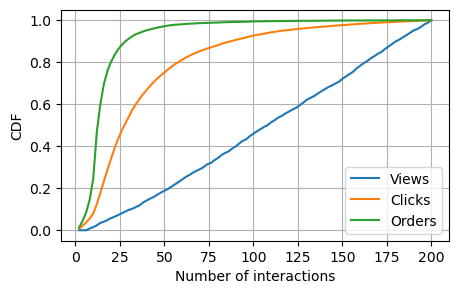

In [20]:
fig, ax = plt.subplots(figsize=(5,3))
iter_dict = {'Views': vdf, 'Clicks':cdf, 'Orders':odf}
for ilbl, idf in iter_dict.items():
    data = idf.groupby('user_idx')['product_idx'].count().values
    xbins, ylocs = get_cdf(data, bins=100, range=(0,200))
    ax.plot(xbins, ylocs, label=ilbl) 
ax.legend()
ax.grid(True)
ax.set_xlabel('Number of interactions')
ax.set_ylabel('CDF')